# Multitask Traning of Diffraction Data

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

I have a Dell Precision 5820 Tower workstation, which contains an NVIDIA Quadro P4000 GPU. 

In [2]:
import sys
print("Python version:", sys.version)
print("TensorFlow version:", tf.__version__)
print("Number of GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Python version: 3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
TensorFlow version: 2.4.0
Number of GPUs Available: 1


In [3]:
labels = pd.read_csv('/scratch/sfd/diffraction/trial2/multiclasses.txt', sep=' ', skiprows = 1, 
                     names=['file', 'blank', 'photo1', 'photo2', 'multilattice', 'ice', 'badice', 'mosaic1', 'mosaic2'])

In [4]:
labels.head()

,file,blank,photo1,photo2,multilattice,ice,badice,mosaic1,mosaic2
0,fake_00001.png,0,1,0,0,1,0,0.892528,0.000000
1,fake_00002.png,0,0,1,1,0,0,0.581729,0.568217
2,fake_00003.png,0,1,0,0,0,0,0.508285,0.000000
3,fake_00004.png,0,1,0,0,0,0,0.852589,0.000000
4,fake_00005.png,0,0,1,0,0,0,0.762097,0.000000


**Note** an image can belong to multi classes. For example, fake_00001.png is both photo1 and ice.

In [5]:
totals = []
for label in ('blank', 'photo1', 'photo2', 'multilattice', 'ice', 'badice'):
    totals.append(labels[labels[label] == 1].shape[0])

totals.append(labels.shape[0])
totals

[114, 22722, 22796, 13345, 9099, 4151, 38742]

**Note** the data is very unbalanced. But maybe multitask training can help.

In [6]:
classes = ['blank', 'photo1', 'photo2', 'multilattice', 'ice', 'badice', 'total']

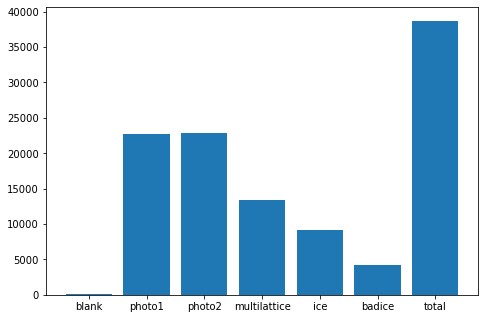

In [7]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(classes,totals)
plt.show()

## Multi-class model

We'll start with a multi-class model.

In [8]:
from tensorflow import keras as k
input_X = k.layers.Input(shape=(512, 512, 1), name="input")
vgg16 = k.applications.vgg16.VGG16(
    include_top=True, 
    weights=None, 
    input_tensor=input_X, 
    input_shape=(512, 512, 1), 
    pooling=max,
    classes=6)

model_mc = k.Model(inputs=input_X, outputs=vgg16.output)
model_mc.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 512, 512, 1)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      640       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0     

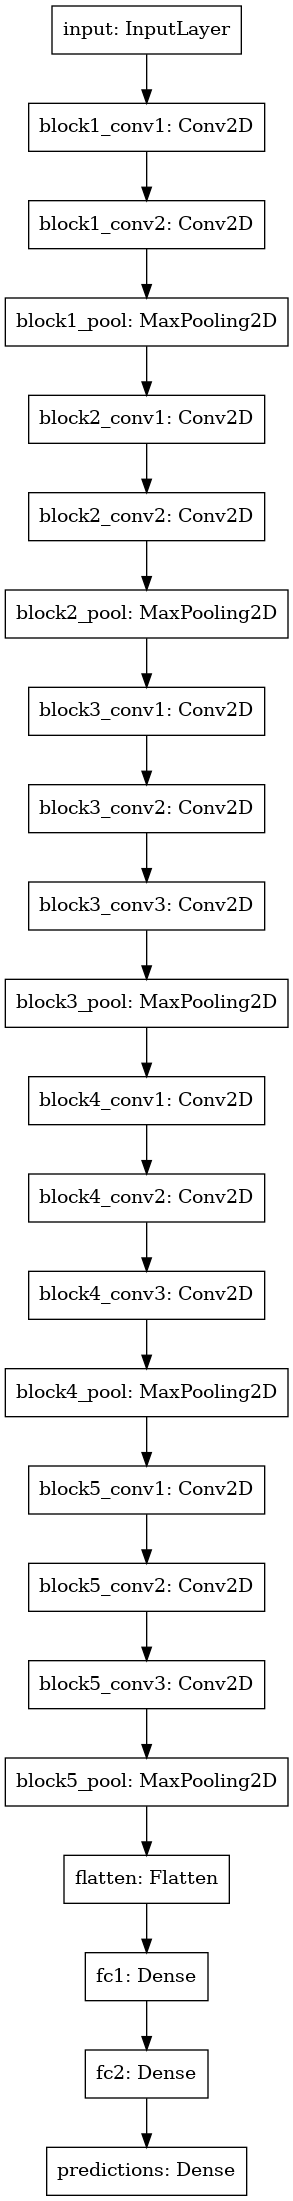

In [9]:
k.utils.plot_model(
    model_mc, to_file='model_mc.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

## Multi-task model

We'll adapt the model-class model into a multi-task model

In [10]:
base = vgg16.layers[-2].output
blank = k.layers.Dense(1, activation='sigmoid', name="blank")(base)
ps1 = k.layers.Dense(1, activation='sigmoid', name="ps1")(base)
ps2 = k.layers.Dense(1, activation='sigmoid', name="ps2")(base)
multi = k.layers.Dense(1, activation='sigmoid', name="multi")(base)
ice = k.layers.Dense(1, activation='sigmoid', name="ice")(base)
badice = k.layers.Dense(1, activation='sigmoid', name="badice")(base)
mos1 = k.layers.Dense(1, name="mos1")(base)
mos2 = k.layers.Dense(1, name="mos2")(base)

In [11]:
model_mt = k.Model(inputs=input_X, outputs=[blank, ps1, ps2, multi, ice, badice, mos1, mos2])

In [12]:
model_mt.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 512, 512, 64) 640         input[0][0]                      
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 512, 512, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 256, 256, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

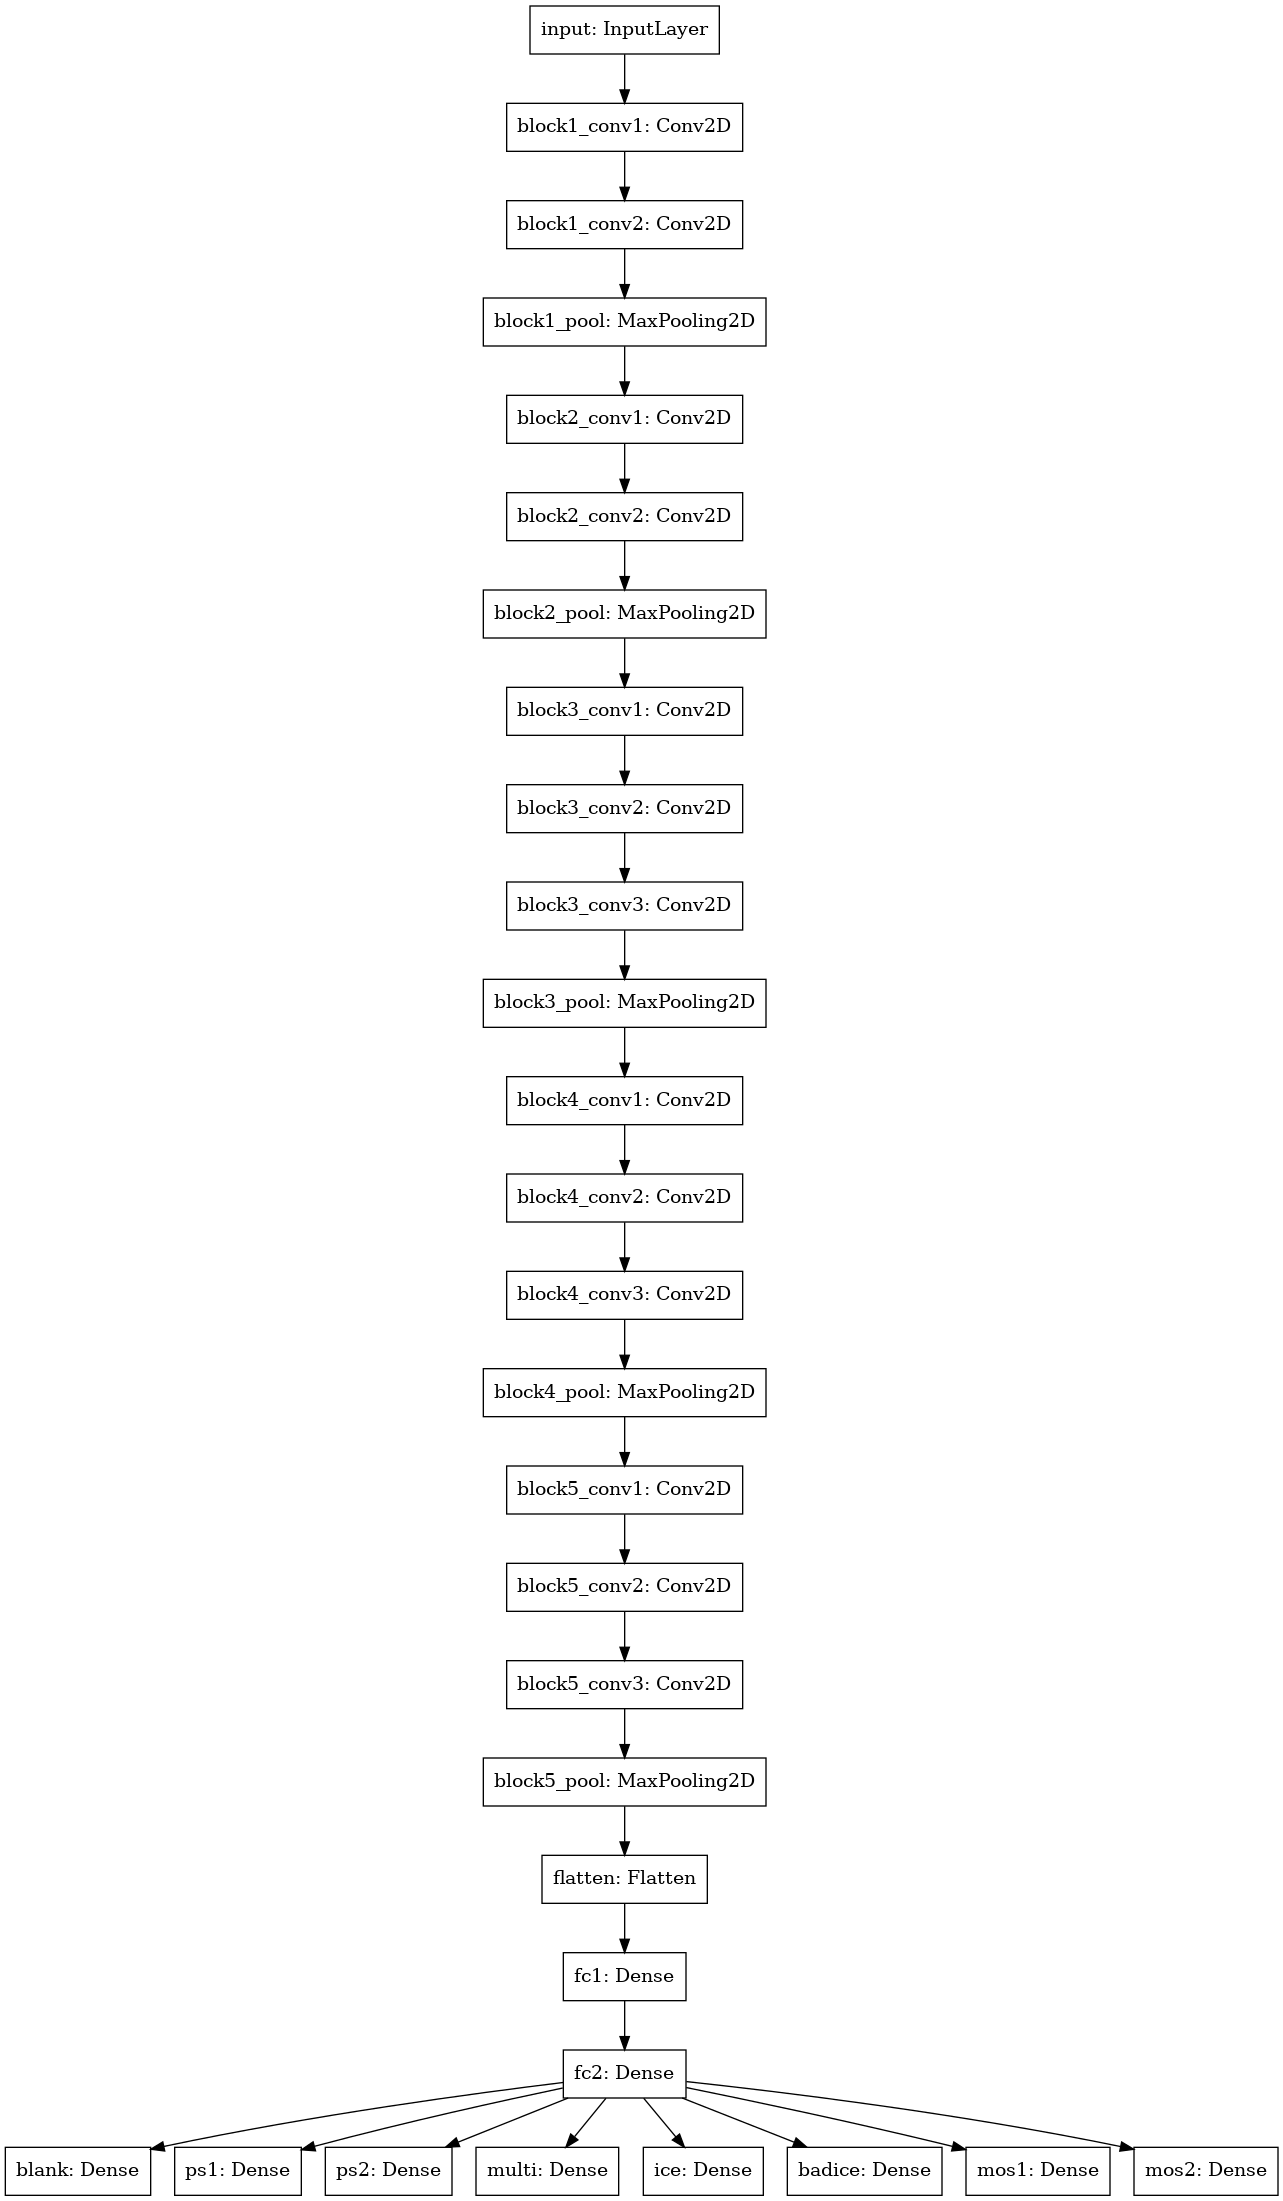

In [13]:
k.utils.plot_model(
    model_mt, to_file='model_mt.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

In [14]:
model_mt.compile(loss={'blank': 'binary_crossentropy', 'ps1': 'binary_crossentropy', 
                       'ps2': 'binary_crossentropy', 'multi': 'binary_crossentropy',
                       'multi': 'binary_crossentropy', 'ice': 'binary_crossentropy',
                       'badice': 'binary_crossentropy', 'mos1': 'mse', 'mos2': 'mse'},
                 loss_weights={'blank': 1., 'ps1': 1., 'ps2': 1., 'multi': 1.,
                       'multi': 1., 'ice': 1., 'badice': 1., 'mos1': 1., 'mos2': 1.},
                 optimizer=k.optimizers.Adam(0.001))